In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from torch.distributions.constraints import simplex, positive
from pyro.infer import Predictive

sns.set_style("white")

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Causal Effect Estimation: California Smoking Cessation Program

In 1989, California passed Proposition 99 which increased cigarette taxes. We will estimate the impact this policy had on cigarette consumption using the California smoking cessation program dataset [2]. This dataset consists of cigarette consumption of 39 states between 1970 to 2000, 38 of which are control units.

We start by loading and visualizing the dataset.

In [12]:
# Let's load the data from the author's github
DATA_URL = "https://raw.githubusercontent.com/synth-inference/synthdid/master/data/california_prop99.csv"
data = pd.read_csv(DATA_URL, sep=";")

# Assign unique integer ids for each state and each time
data["unit_index"] = pd.factorize(data["State"].values)[0]
data["time_index"] = pd.factorize(data["Year"].values)[0]

# Model below assumes the response is coded as "y"
data["y"] = data["PacksPerCapita"].values.copy()

# Assign each unit to treatment or control group
data["in_treatment_group"] = 0
treated_units = data[data["treated"] == 1]["State"].unique()
data.loc[data["State"].isin(treated_units), "in_treatment_group"] = 1

<IPython.core.display.Javascript object>

In [13]:
# Show first few rows of the dataset
data.head()

,State,Year,PacksPerCapita,treated,unit_index,time_index,y,in_treatment_group
0,Alabama,1970,89.800003,0,0,0,89.800003,0
1,Arkansas,1970,100.300003,0,1,0,100.300003,0
2,Colorado,1970,124.800003,0,2,0,124.800003,0
3,Connecticut,1970,120.000000,0,3,0,120.000000,0
4,Delaware,1970,155.000000,0,4,0,155.000000,0


<IPython.core.display.Javascript object>

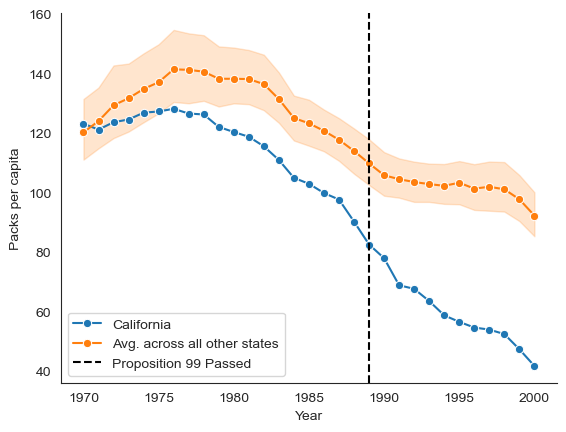

<IPython.core.display.Javascript object>

In [25]:
sns.lineplot(
    x=data[data["State"] == "California"]["Year"],
    y=data[data["State"] == "California"]["PacksPerCapita"],
    marker="o",
    label='California',
)

# The shaded area is the plot is the 95% confidence interval around the mean
sns.lineplot(
    x=data[data["State"] != "California"]["Year"],
    y=data[data["State"] != "California"]["PacksPerCapita"],
    marker="o",
    label='Avg. across all other states',
)

plt.axvline(
    1989, label="Proposition 99 Passed", color="black", linestyle="dashed"
)
plt.ylabel("Packs per capita")
sns.despine()
plt.legend()

### We would like to estimate a counterfactual: had California not raised cigarette taxes, what would have cigarette consumption been?

To estimate this effect, we implement a Bayesian analogue of the Synthetic Difference-in-Differences (SDID) estimator proposed in [1]. 

In [56]:
class BayesSDID(pyro.nn.PyroModule):
    def __init__(self, X: pd.DataFrame):
        """
        Input:
            X: dataframe with columns "unit_index", "time_index", "in_treatment_group", "y", "treated"
        """
        super().__init__()
        self.X = X.copy() # TODO: sort as necessary
        units_by_group = X[["unit_index", "in_treatment_group"]].drop_duplicates()
        self.N = units_by_group.shape[0] # number of units
        self.N_tr = units_by_group["in_treatment_group"].sum()  # number of treated units
        self.N_co = self.N - self.N_tr  # number of control units
        self.T_pre = X[X["treated"] == 1]["time_index"].min()  # number of pre-treatment periods
        self.T_post = data["time_index"].max() - self.T_pre + 1  # number of post-treatment periods
        self.T = self.T_pre + self.T_post  # total number of periods
        self.times_by_units = torch.tensor(pd.pivot_table(X, values="y", index="time_index", columns="unit_index").values).float()
        self.avg_y_post_treat = self.times_by_units[self.T_pre:, self.N_co:].mean(axis=0)  # average of each treated unit over the post-treatment period
        self.y_pre_treat_tr_avg = self.times_by_units[:self.T_pre, self.N_co:].mean(axis=1)
        self.y = torch.tensor(X["y"].values)
        self.treated = torch.tensor(data["treated"].values)
        self.unit_index = list(X["unit_index"].values)
        self.time_index = list(X["time_index"].values)

    def sample_synthetic_control_weights(self):
        w0 = pyro.sample("w0", dist.Normal(0, 1)) # intercept
        w_co = pyro.sample("w_co", dist.Dirichlet(torch.ones(self.N_co))) # convex combination of control units
        return w0, w_co
    
    def sample_time_weights(self):
        lam_0 = pyro.sample("lam_0", dist.Normal(0, 1)) # intercept
        lam_pre = pyro.sample("lam_pre", dist.Dirichlet(torch.ones(self.T_pre))) # convex combination of time periods
        return lam_0, lam_pre

    def sample_response_params(self, prior_scale=10):
        # Intercept, time fixed effects, treatment effect, unit fixed effects 
        mu = pyro.sample("mu", dist.Normal(0, prior_scale))
        beta = pyro.sample("beta", dist.Normal(0, prior_scale).expand((self.T,)).to_event(1))
        tau = pyro.sample("tau", dist.Normal(0, prior_scale))
        alpha = pyro.sample( "alpha", dist.Normal(0, 10.).expand((self.N,)).to_event(1))
        return mu, beta, tau, alpha
    
    def synthetic_control_unit(self, times_by_units: torch.Tensor, w0: torch.Tensor, w_co: torch.Tensor):
        return w0 + times_by_units.mv(w_co)
            
    def time_control(self, units_by_time: torch.Tensor, lam_0, lam_pre):
        return lam_0 + units_by_time.mv(lam_pre)

    def forward(self, **kwargs):        
        # Sample synthetic control weights, time weights, response parameters
        w0, w_co = self.sample_synthetic_control_weights()
        w_co_tr = torch.cat([w_co, 1 / self.N_tr * torch.ones(self.N_tr)]) # TODO: this assumes
        lam_0, lam_pre = self.sample_time_weights()
        lam_pre_post = torch.cat([lam_pre, 1 / self.T_post * torch.ones(self.T_post)]) # TODO: this assumes
        mu, beta, tau, alpha = self.sample_response_params(**kwargs)
        
        # Synthetic control weights likelihood
        y_sc = self.synthetic_control_unit(self.times_by_units[:self.T_pre, :self.N_co], w0, w_co)
        with pyro.plate("synthetic_control_weights", self.T_pre):
            pyro.sample("y_pre_treat_tr_avg", dist.Normal(y_sc, 1.0), obs=self.y_pre_treat_tr_avg)

        # Time weights likelihood
        y_time = self.time_control(self.times_by_units[:self.T_pre, :].T, lam_0, lam_pre)
        with pyro.plate("time_weights", self.N):
            pyro.sample("avg_y_post_treat", dist.Normal(y_time, 1.0), obs=self.avg_y_post_treat)

        # Response likelihood
        weights = w_co_tr[self.unit_index] * lam_pre_post[self.time_index]
        f = mu + beta[self.time_index] + alpha[self.unit_index] + tau * self.treated
        with pyro.plate("response", self.N * self.T):
            pyro.sample("y", dist.Normal(f, 1 / weights), obs=self.y)


<IPython.core.display.Javascript object>

### Let's visualize Bayesian SDID probabilistic model.

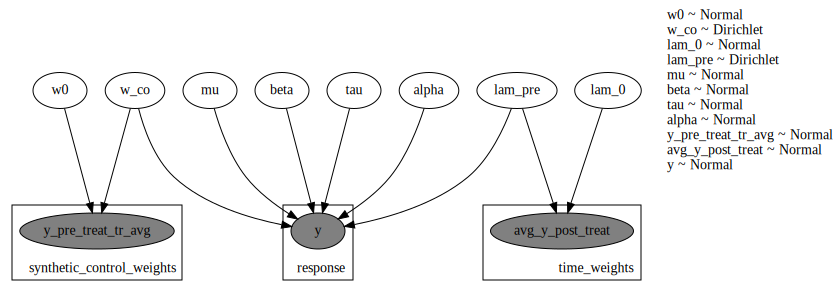

<Figure size 1200x500 with 0 Axes>

<IPython.core.display.Javascript object>

In [70]:
plt.figure(figsize=(12, 5))
pyro.render_model(BayesSDID(data), render_params=True, render_distributions=True)

# References
1. https://www.aeaweb.org/articles?id=10.1257/aer.20190159
2. https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746